# 🏭 Hackathon - Détection de Défauts Industriels avec IA

## 📋 Objectif
Construire un système complet de détection de défauts sur des pièces industrielles en utilisant:
- **Machine Learning / Deep Learning** pour la classification
- **CBIR** (Content-Based Image Retrieval) pour la recherche par similarité
- **VLM** (Vision Language Model) pour la description automatique

---

## 🗓️ Programme
| Jour | Thème | Livrables |
|------|-------|----------|
| 1 | Fondamentaux | Pipeline ML/DL baseline |
| 2 | Optimisation | Hyperparamètres + Interface Streamlit |
| 3 | CBIR | Système de recherche par similarité |
| 4 | VLM | Description automatique + Intégration finale |

---

## ⚠️ Règles du Hackathon
- ✅ Utiliser les ressources fournies
- ✅ Collaborer en équipe
- ✅ Documenter votre code
- ❌ Ne pas copier le code final des autres équipes

**Bonne chance! 🚀**

---
# 📦 SECTION 0: Configuration de l'Environnement
---

In [ ]:
# Installation des dépendances (décommenter si nécessaire)
!pip install torch torchvision scikit-learn xgboost lightgbm
!pip install matplotlib seaborn pillow
!pip install transformers accelerate  # Pour VLM

In [ ]:
# Imports de base
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Deep Learning
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

PyTorch version: 2.9.0+cpu
CUDA available: False
Using device: cpu


In [ ]:
# Configuration des chemins - À MODIFIER selon votre structure
DATA_DIR = Path("drive/MyDrive/SKEMA/Hackathon/data")
TRAIN_DIR = DATA_DIR / "train"
TEST_DIR = DATA_DIR / "test"
MODELS_DIR = Path("./models")
MODELS_DIR.mkdir(exist_ok=True)

# Classes
CLASSES = ['ok_front', 'def_front']
NUM_CLASSES = 2

# Paramètres images
IMG_SIZE = 224
BATCH_SIZE = 32

In [ ]:
print("Train exists:", TRAIN_DIR.exists())
print("Test exists:", TEST_DIR.exists())

Train exists: True
Test exists: True


In [ ]:
os.getcwd()

'/Users/solenedebreuil/Documents/_Master Spécialisé IA SKEMA/Hackathon Mc2i'

---
# 📊 SECTION 1: Exploration des Données (EDA)
---

## 💡 Objectif
Comprendre la distribution de vos données avant de construire le modèle.

## 🎯 TODO pour votre équipe:
1. Compter le nombre d'images par classe
2. Visualiser quelques exemples
3. Vérifier la taille et qualité des images

In [ ]:
# TODO: Compléter cette fonction pour compter les images

import os

def count_images(directory):
    """
    Compte le nombre d'images par classe dans un répertoire.

    Args:
        directory: Chemin vers le répertoire (train ou test)

    Returns:
        dict: {'def_front': count, 'ok_front': count}
    """
    counts = {}

    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)

        # Vérifie que c'est bien un dossier
        if os.path.isdir(class_path):
            image_count = 0

            for file in os.listdir(class_path):
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image_count += 1

            counts[class_name] = image_count

    return counts

# Test
print("Distribution Train:", count_images(TRAIN_DIR))
print("Distribution Test:", count_images(TEST_DIR))

Distribution Train: {'ok_front': 2871, 'def_front': 2398, '.ipynb_checkpoints': 0}
Distribution Test: {'ok_front': 262, 'def_front': 148, '.ipynb_checkpoints': 0}


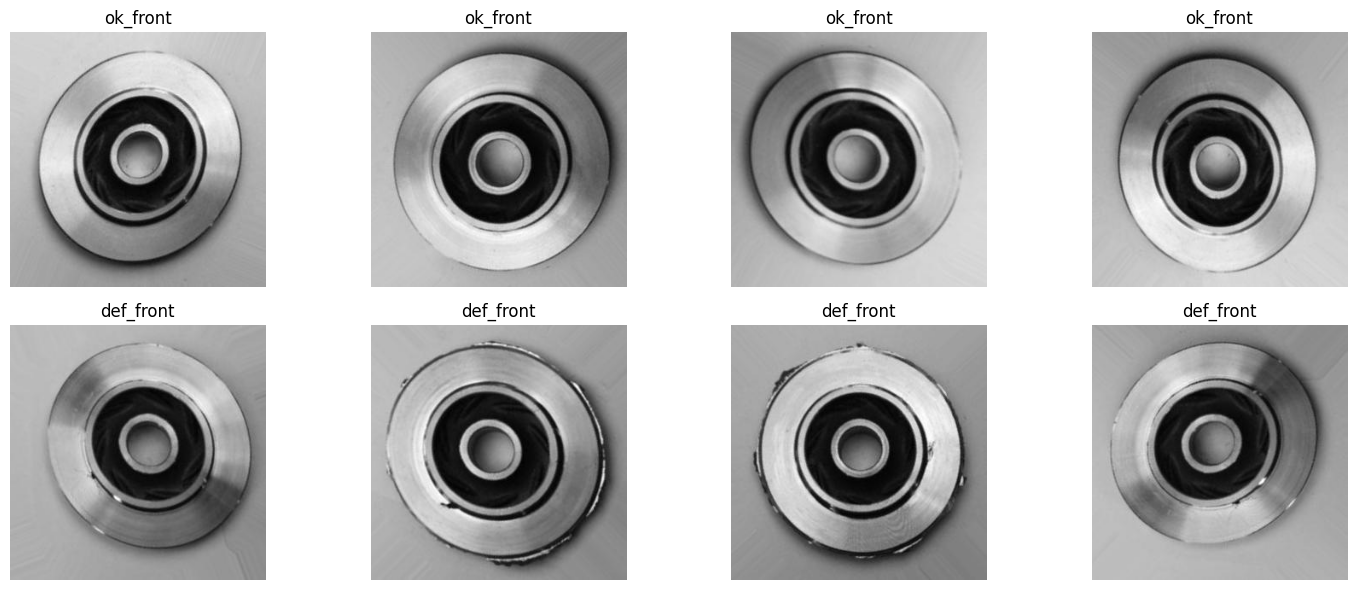

In [ ]:
# TODO: Visualiser des exemples d'images

def visualize_samples(directory, n_samples=4):
    """
    Affiche des exemples d'images pour chaque classe.

    Hint: Utilisez matplotlib avec subplot
    """
    fig, axes = plt.subplots(2, n_samples, figsize=(15, 6))

    for i, class_name in enumerate(CLASSES):
        class_dir = directory / class_name

        #1
        image_files = [
            f for f in class_dir.iterdir()
            if f.suffix.lower() in ['.jpg', '.jpeg', '.png']
        ]

        #2
        selected_images = random.sample(image_files, min(n_samples, len(image_files)))

        #3
        for j, img_path in enumerate(selected_images):
            img = Image.open(img_path)
            axes[i, j].imshow(img)
            axes[i, j].set_title(class_name)
            axes[i, j].axis("off")
            pass

    plt.tight_layout()
    plt.show()

visualize_samples(TRAIN_DIR)

### ❓ Questions de réflexion:
1. Vos classes sont-elles équilibrées?

- On a beaucoup plus de OK que de DEF dans le train set, c'est le même dans le test set (quasiment le double de OK par rapport aux defectueuses)

2. Quelles caractéristiques visuelles distinguent les défauts?

- On voit des tâches sur les disques, de petits creux.

3. Y a-t-il des variations de luminosité/angle dans les images?

- Oui, on voit que les reflets de lumière sont différents, les angles de prise de vue aussi.

---
# 🖼️ SECTION 2: Prétraitement des Images
---

## 💡 Concepts clés

### Normalisation ImageNet
Les modèles pré-entraînés (VGG, ResNet) attendent des images normalisées:
- **Mean**: [0.485, 0.456, 0.406]
- **Std**: [0.229, 0.224, 0.225]

### Data Augmentation
Techniques pour augmenter artificiellement le dataset:
- Rotation, flip horizontal
- Variation de luminosité
- Crop aléatoire

In [ ]:
# Transforms pour l'entraînement (avec augmentation)
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Transforms pour test/inférence (PAS d'augmentation)
test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

print("✅ Transforms définis")

✅ Transforms définis


In [ ]:
# TODO: Créer un Dataset personnalisé
class DefectDataset(Dataset):
    """
    Dataset pour les images de défauts.

    Structure attendue:
    data_dir/
    ├── defective/
    │   └── *.jpg, *.png
    └── non_defective/
        └── *.jpg, *.png
    """

    def __init__(self, data_dir, transform=None):
        self.data_dir = Path(data_dir)
        self.transform = transform
        self.samples = []  # Liste de (chemin_image, label)

        for class_name in CLASSES:
            class_dir = self.data_dir / class_name

            # Définition du label
            if class_name == "ok_front":
                label = 0
            elif class_name == "def_front":
                label = 1
            else:
                continue

            # Parcourir les images
            for img_path in class_dir.iterdir():
                if img_path.suffix.lower() in [".jpg", ".jpeg", ".png"]:
                    self.samples.append((img_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]

        # Charger l'image
        image = Image.open(img_path).convert("RGB")

        # Appliquer les transformations si elles existent
        if self.transform:
            image = self.transform(image)

        return image, label

# Test
train_dataset = DefectDataset(TRAIN_DIR, transform=train_transform)
print(f"Nombre d'images: {len(train_dataset)}")

Nombre d'images: 5269


---
# 🧠 SECTION 3: Extraction de Caractéristiques avec CNN
---

## 💡 Concept: Transfer Learning

Utiliser un CNN pré-entraîné sur ImageNet comme **extracteur de features**:
1. Charger le modèle (VGG16, ResNet50, etc.)
2. Retirer la dernière couche (classification)
3. Passer l'image → Obtenir un vecteur de features

### Dimensions des features par modèle:
| Modèle | Dimension |
|--------|----------|
| VGG16 | 4096 |
| ResNet50 | 2048 |
| DenseNet121 | 1024 |
| MobileNetV2 | 1280 |

In [ ]:
# Exemple: Feature Extractor avec ResNet50
class FeatureExtractor(nn.Module):
    """
    Extrait les features d'une image en utilisant un CNN pré-entraîné.
    """

    def __init__(self, model_name='resnet50'):
        super().__init__()

        if model_name == 'resnet50':
            base_model = models.resnet50(pretrained=True)
            # Retirer la dernière couche FC
            self.features = nn.Sequential(*list(base_model.children())[:-1])
            self.output_dim = 2048

        elif model_name == 'vgg16':
            base_model = models.vgg16(pretrained=True)
            self.features = base_model.features
            self.avgpool = base_model.avgpool
            # Utiliser seulement les features, pas le classifier
            self.output_dim = 512 * 7 * 7  # 25088

        # TODO: Ajouter d'autres modèles (DenseNet, MobileNet)

        # Geler les poids (pas de fine-tuning)
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        return x

# Test
extractor = FeatureExtractor('resnet50').to(DEVICE)
extractor.eval()

# Test avec une image aléatoire
dummy_img = torch.randn(1, 3, 224, 224).to(DEVICE)
features = extractor(dummy_img)
print(f"Shape des features: {features.shape}")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 123MB/s]


Shape des features: torch.Size([1, 2048])


In [ ]:
# TODO: Extraire les features de tout le dataset
def extract_all_features(data_dir, extractor, transform):
    """
    Extrait les features de toutes les images d'un répertoire.

    Returns:
        features: np.array de shape (n_samples, feature_dim)
        labels: np.array de shape (n_samples,)
        paths: liste des chemins d'images
    """
    features_list = []
    labels_list = []
    paths_list = []

    extractor.eval()

    # TODO: Parcourir les images et extraire les features
    # Hint:
    # 1. Charger l'image avec PIL
    # 2. Appliquer transform
    # 3. Passer dans extractor
    # 4. Ajouter aux listes

    with torch.no_grad():
        for class_name in CLASSES:
            class_dir = Path(data_dir) / class_name

            # Définition du label
            label = 1 if class_name == "def_front" else 0

            for img_path in class_dir.iterdir():
                if img_path.suffix.lower() in [".jpg", ".jpeg", ".png"]:

                # 1. Charger l'image
                    image = Image.open(img_path).convert("RGB")

                # 2. Appliquer transform
                    image = transform(image)

                # Ajouter dimension batch (1, C, H, W)
                    image = image.unsqueeze(0)

                # 3. Passer dans extractor
                    features = extractor(image)

                # Si sortie tensor 2D ou 4D, on aplati
                    features = features.squeeze().cpu().numpy()

                # 4. Ajouter aux listes
                    features_list.append(features)
                    labels_list.append(label)
                    paths_list.append(str(img_path))

    return np.array(features_list), np.array(labels_list), paths_list
# Extraction
X_train, y_train, paths_train = extract_all_features(TRAIN_DIR, extractor, test_transform)
print(f"Features train: {X_train.shape}")

Features train: (5269, 2048)


---
# 🧠 SECTION 3b: Entraînement CNN Baseline (Deep Learning)
---

## 💡 Objectif
Entraîner un CNN from scratch pour comparer avec l'approche hybride (features pré-entraînées + shallow classifiers).

### Architecture suggérée:
```
Input (224×224×3)
    ↓
Conv2D(32) → BatchNorm → ReLU → MaxPool
    ↓
Conv2D(64) → BatchNorm → ReLU → MaxPool
    ↓
Conv2D(128) → BatchNorm → ReLU → MaxPool
    ↓
Conv2D(256) → BatchNorm → ReLU → MaxPool
    ↓
Global Average Pooling
    ↓
FC(256) → ReLU → Dropout
    ↓
FC(2) → Softmax
```

In [ ]:
# TODO: Définir le CNN Baseline
class BaselineCNN(nn.Module):
    """
    CNN personnalisé pour la classification de défauts.
    """

    def __init__(self, num_classes=2):
        super().__init__()

        # TODO: Définir les couches convolutionnelles
        # Hint: nn.Conv2d(in_channels, out_channels, kernel_size)
        # Hint: nn.BatchNorm2d(num_features)
        # Hint: nn.MaxPool2d(kernel_size)

        self.features = nn.Sequential(
            # Block 1: 3 → 32
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            # Block 2: 32 → 64
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            # Block 3: 64 → 128
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            # Block 4: 128 → 256
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
             nn.MaxPool2d(2),
        )

        # Global Average Pooling
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Test
model = BaselineCNN().to(DEVICE)
dummy = torch.randn(1, 3, 224, 224).to(DEVICE)
output = model(dummy)
print(f"Output shape: {output.shape}")  # Devrait être (1, 2)

Output shape: torch.Size([1, 2])


In [ ]:
# TODO: Fonction d'entraînement du CNN
def train_cnn(model, train_loader, val_loader, epochs=20, lr=0.001):
    """
    Entraîne le CNN avec early stopping.

    Args:
        model: Le CNN à entraîner
        train_loader: DataLoader d'entraînement
        val_loader: DataLoader de validation
        epochs: Nombre d'époques maximum
        lr: Learning rate

    Returns:
        model: Le modèle entraîné
        history: Dict avec les métriques par époque
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3
    )

    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        # TODO: Implémenter la boucle d'entraînement
        # 1. model.train()
        # 2. Pour chaque batch: forward → loss → backward → step
        # 3. model.eval() pour validation
        # 4. Calculer val_loss et val_acc
        # 5. Early stopping si pas d'amélioration

        # --------------------
        # TRAIN
        # --------------------
        model.train()
        train_loss = 0.0

        for images, labels in train_loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)

        train_loss /= len(train_loader.dataset)

        # --------------------
        # VALIDATION
        # --------------------
        model.eval()
        val_loss = 0.0
        correct = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(DEVICE)
                labels = labels.to(DEVICE)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)

                preds = torch.argmax(outputs, dim=1)
                correct += (preds == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_acc = correct / len(val_loader.dataset)


        # Scheduler
        scheduler.step(val_loss)


        # Sauvegarde historique
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)


        # --------------------
        # EARLY STOPPING
        # --------------------
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1

        if patience_counter >= 5:
            print("Early stopping déclenché")
            break

        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        print(f"Epoch {epoch+1}/{epochs}")

    return model, history

In [ ]:
from torchvision import transforms

# Transformations pour l'entraînement (augmentation + normalisation)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

# Transformations pour la validation/test (juste resize + tensor)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Créer les DataLoaders
train_dataset = DefectDataset(TRAIN_DIR, transform=train_transform)
val_dataset = DefectDataset(TEST_DIR, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
# Entraînement
cnn_model = BaselineCNN().to(DEVICE)
cnn_model, history = train_cnn(cnn_model, train_loader, val_loader, epochs=20)

Train Loss: 0.3472 | Val Loss: 4.4971 | Val Acc: 0.3610
Epoch 1/20
Train Loss: 0.1688 | Val Loss: 13.4921 | Val Acc: 0.3610
Epoch 2/20


torch.save(cnn_model.state_dict(), "baseline_cnn.pth")

model = BaselineCNN().to(DEVICE)
model.load_state_dict(torch.load("baseline_cnn.pth"))
model.eval()  # Toujours mettre en mode évaluation si tu fais des prédictions

In [ ]:
# TODO: Visualiser les courbes d'apprentissage
def plot_training_history(history):
    """
    Affiche les courbes de loss et accuracy.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Loss
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Val Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.set_title('Training & Validation Loss')

    # Accuracy
    ax2.plot(history['val_acc'], label='Val Accuracy', color='green')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.set_title('Validation Accuracy')

    plt.tight_layout()
    plt.show()

# plot_training_history(history)

### 💡 Optimisation du CNN (si nécessaire)

Si les performances ne sont pas satisfaisantes:
1. **Data Augmentation** plus agressive
2. **Learning Rate Scheduler** (ReduceLROnPlateau)
3. **Regularization** (Dropout, Weight Decay)
4. **Architecture** (plus de couches, plus de filtres)
5. **Transfer Learning** (fine-tuning d'un modèle pré-entraîné)

In [ ]:
# TODO: Fine-tuning d'un modèle pré-entraîné (alternative au CNN from scratch)
def create_finetuned_model(model_name='resnet50', num_classes=2, freeze_ratio=0.8):
    """
    Crée un modèle pré-entraîné pour fine-tuning.

    Args:
        model_name: 'resnet50', 'vgg16', etc.
        num_classes: Nombre de classes (2 pour notre cas)
        freeze_ratio: Proportion des couches à geler (0.8 = 80% gelées)
    """
    if model_name == 'resnet50':
        model = models.resnet50(pretrained=True)
        # Remplacer la dernière couche
        model.fc = nn.Linear(model.fc.in_features, num_classes)

        # Geler les premières couches
        layers = list(model.children())
        freeze_until = int(len(layers) * freeze_ratio)
        for i, layer in enumerate(layers[:freeze_until]):
            for param in layer.parameters():
                param.requires_grad = False

    # TODO: Ajouter VGG16, DenseNet si besoin

    return model

# model_ft = create_finetuned_model('resnet50').to(DEVICE)

---
# 📊 SECTION 3c: Comparaison CNN vs Shallow Methods
---

## 🎯 Objectif
Comparer les performances de:
1. **CNN Baseline** (entraîné from scratch)
2. **CNN Fine-tuné** (transfer learning)
3. **Features pré-entraînées + Shallow Classifiers**

In [ ]:
# TODO: Créer un tableau de comparaison
def compare_models(models_results):
    """
    Compare les performances de plusieurs modèles.

    Args:
        models_results: Dict {'model_name': {'accuracy': ..., 'recall': ..., 'f1': ...}}

    Returns:
        DataFrame avec la comparaison
    """
    df = pd.DataFrame(models_results).T
    df = df.sort_values('f1', ascending=False)

    # Afficher avec style
    styled = df.style.background_gradient(cmap='Greens', subset=['accuracy', 'recall', 'f1'])

    return styled

# Exemple d'utilisation:
# results = {
#     'CNN Baseline': {'accuracy': 0.85, 'precision': 0.83, 'recall': 0.80, 'f1': 0.82},
#     'ResNet50 + SVM': {'accuracy': 0.90, 'precision': 0.89, 'recall': 0.88, 'f1': 0.89},
#     'ResNet50 + XGBoost': {'accuracy': 0.92, 'precision': 0.91, 'recall': 0.90, 'f1': 0.91},
#     'VGG16 + RandomForest': {'accuracy': 0.88, 'precision': 0.86, 'recall': 0.85, 'f1': 0.86},
# }
# compare_models(results)

In [ ]:
# Visualisation graphique de la comparaison
def plot_model_comparison(results):
    """
    Graphique de comparaison des modèles.
    """
    df = pd.DataFrame(results).T.reset_index()
    df = df.rename(columns={'index': 'Model'})

    fig, ax = plt.subplots(figsize=(10, 6))

    x = np.arange(len(df))
    width = 0.2

    ax.bar(x - width, df['accuracy'], width, label='Accuracy', color='#2E86AB')
    ax.bar(x, df['recall'], width, label='Recall', color='#F18F01')
    ax.bar(x + width, df['f1'], width, label='F1-Score', color='#4CAF50')

    ax.set_ylabel('Score')
    ax.set_title('Comparaison des Modèles')
    ax.set_xticks(x)
    ax.set_xticklabels(df['Model'], rotation=45, ha='right')
    ax.legend()
    ax.set_ylim(0, 1)
    ax.axhline(y=0.9, color='red', linestyle='--', alpha=0.5, label='Objectif 90%')

    plt.tight_layout()
    plt.show()

# plot_model_comparison(results)

---
# 🗳️ SECTION 3d: Ensemble - Vote Majoritaire
---

## 💡 Concept

Combiner les prédictions de plusieurs modèles:
- Si la majorité prédit "Défaut" → Prédiction finale = "Défaut"
- Confiance = nombre de votes pour la classe gagnante / total des modèles

### Avantages:
- Plus robuste qu'un seul modèle
- Réduit le risque de faux négatifs
- Capture différentes "perspectives" sur les données

In [ ]:
class EnsemblePredictor:
    """
    Prédicteur ensemble avec vote majoritaire.
    """

    def __init__(self):
        self.models = {}  # {'model_name': (model, feature_extractor, scaler)}
        self.cnn_models = {}  # CNN models qui prédisent directement

    def add_shallow_model(self, name, model, feature_extractor, scaler):
        """
        Ajoute un modèle shallow (SVM, XGBoost, etc.)
        """
        self.models[name] = {
            'model': model,
            'extractor': feature_extractor,
            'scaler': scaler
        }

    def add_cnn_model(self, name, model):
        """
        Ajoute un modèle CNN (prédit directement sur l'image)
        """
        self.cnn_models[name] = model

    def predict(self, image_tensor):
        """
        Prédit avec vote majoritaire.

        Args:
            image_tensor: Tensor de l'image (1, 3, 224, 224)

        Returns:
            dict: {
                'prediction': 0 ou 1,
                'confidence': float,
                'votes': {'defective': n, 'non_defective': m},
                'model_predictions': {'model_name': pred, ...}
            }
        """
        predictions = {}

        # TODO: Prédictions des CNN
        for name, model in self.cnn_models.items():
            model.eval()
            with torch.no_grad():
                output = model(image_tensor.to(DEVICE))
                pred = output.argmax(dim=1).item()
                predictions[name] = pred

        # TODO: Prédictions des shallow models
        for name, components in self.models.items():
            extractor = components['extractor']
            scaler = components['scaler']
            model = components['model']

            # Extraire features
            extractor.eval()
            with torch.no_grad():
                features = extractor(image_tensor.to(DEVICE))
                features = features.cpu().numpy().flatten().reshape(1, -1)

            # Normaliser
            features_scaled = scaler.transform(features)

            # Prédire
            pred = model.predict(features_scaled)[0]
            predictions[name] = pred

        # Vote majoritaire
        votes = list(predictions.values())
        defective_votes = sum(votes)
        non_defective_votes = len(votes) - defective_votes

        final_pred = 1 if defective_votes > non_defective_votes else 0
        confidence = max(defective_votes, non_defective_votes) / len(votes)

        return {
            'prediction': final_pred,
            'class_name': 'Defective' if final_pred == 1 else 'Non-Defective',
            'confidence': confidence,
            'votes': {
                'defective': defective_votes,
                'non_defective': non_defective_votes
            },
            'model_predictions': predictions
        }

# Exemple d'utilisation:
# ensemble = EnsemblePredictor()
# ensemble.add_cnn_model('CNN_Baseline', cnn_model)
# ensemble.add_shallow_model('ResNet50_SVM', svm_model, resnet_extractor, scaler)
# result = ensemble.predict(image_tensor)
# print(result)

---
# 🎯 SECTION 4: Entraînement des Classifiers
---

## 💡 Approche Hybride
Deep Features (CNN) + Shallow Classifiers (ML)

### Classifiers à tester:
1. **SVM** - Support Vector Machine
2. **Random Forest** - Ensemble d'arbres
3. **XGBoost** - Gradient Boosting

In [ ]:
# Normalisation des features (IMPORTANT!)
scaler = StandardScaler()

# TODO: Normaliser vos features
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)  # Utiliser le même scaler!

In [ ]:
# TODO: Entraîner un SVM
def train_svm(X_train, y_train):
    """
    Entraîne un SVM avec kernel RBF.

    Hint: sklearn.svm.SVC
    Paramètres importants: C, kernel, gamma
    """
    # VOTRE CODE ICI
    model = None
    return model

# TODO: Entraîner un Random Forest
def train_random_forest(X_train, y_train):
    """
    Entraîne un Random Forest.

    Paramètres importants: n_estimators, max_depth
    """
    # VOTRE CODE ICI
    model = None
    return model

---
# 📏 SECTION 5: Évaluation du Modèle
---

## 💡 Métriques importantes

Dans le contexte industriel:
- **Recall** est CRITIQUE (ne pas manquer de défauts)
- **F1-Score** pour la balance globale

In [ ]:
def evaluate_model(model, X_test, y_test):
    """
    Évalue un modèle et affiche les métriques.
    """
    # Prédictions
    y_pred = model.predict(X_test)

    # Métriques
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print("=" * 50)
    print("RÉSULTATS D'ÉVALUATION")
    print("=" * 50)
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}  ⬅️ IMPORTANT!")
    print(f"F1-Score:  {f1:.4f}")
    print("=" * 50)

    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Défaut', 'Défaut'],
                yticklabels=['Non-Défaut', 'Défaut'])
    plt.xlabel('Prédit')
    plt.ylabel('Réel')
    plt.title('Matrice de Confusion')
    plt.show()

    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}

# Usage:
# results = evaluate_model(svm_model, X_test_scaled, y_test)